In [2]:
%pylab inline
from astropy.io import fits
import glob
import pandas as pd
from pandas import DataFrame
from scipy.interpolate import interp1d
from nirspec import gluespec #divspec, gluespec
import pdb as pdb
import astropy
from astropy import units as u
from astroquery.hitran import Hitran
from flux_calculator import extract_hitran_data, calc_fluxes, extract_vup, make_rotation_diagram
import numpy as np
import pdb as pdb
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Pull and define a src and std to work with
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20130101*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    #print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

srcfile='ABAUR_20130101_1056_spec1d1.fits' #there is a very large peak I cannot resolve. Might want to mess around with more
stdfile='HR1620_20130101_1028_spec1d1.fits'

In [6]:
#Read in data for source and standard
hdulist_src=fits.open(datadir+srcfile)
data_src=hdulist_src[1].data
hdr_src=hdulist_src[0].header
hdulist_std=fits.open(datadir+stdfile)
data_std=hdulist_std[1].data
    
    #Calculate the median without non-CO Emission Lines
    
    #Correcting for pflux_src outliers
list_length = 1024
corrected_data = np.zeros(list_length) 
for m in range(list_length):
    data = np.array(data_src['flux_pos'])
    val = np.median(data)*1.1
    if data[m] < val:
        corrected_data[m] = data[m] + 1 #double check this is how I can do this, also good that original data set is not altered
    else :
        corrected_data[m] = None
corrected_median_pflux_src = np.nanmedian(corrected_data)
print(val)
print(np.median(data))
print(corrected_median_pflux_src)
    
    #correcting for nflux_src outliers
corrected_data = np.zeros(list_length)
for n in range(list_length):
    data = np.array(data_src['flux_neg'])
    val = np.median(data)*1.1
    if data[n] < val:
        corrected_data[n] = data[n] + 1
    else :
        corrected_data[n] = None
        data = np.array(data_src['flux_neg'])

corrected_median_nflux_src = np.nanmedian(corrected_data)
print(val)
print(np.median(data))
print(corrected_median_nflux_src)
    
    #Normalize spectra
pflux_src=data_src['flux_pos']/corrected_median_pflux_src
nflux_src=data_src['flux_neg']/corrected_median_nflux_src
pflux_std=data_std['flux_pos']/np.median(data_std['flux_pos'])
nflux_std=data_std['flux_neg']/np.median(data_std['flux_neg'])

386944.1090664119
351767.37187855627
342108.26589761383
389383.9671973911
353985.424724901
342987.2313604535


In [116]:
#First attempt to establish a cutoff with NaN values
'''
t = Table.read('/Users/hanna/Desktop/URSI/data/data/ABAUR_20130101_1056_spec1d1.fits')
dfsrc = t.to_pandas()
dfsrc = DataFrame(dfsrc, columns = ['wave_pos', 'flux_pos', 'wave_neg', 'flux_neg'])
dfsrc.loc[dfsrc['flux_pos'] > 0, 'flux_pos'] = None

#print(np.median(data_src['flux_pos']))
'''

for n in range(len(pflux_src)):
    val = data_src['flux_pos']
    val = np.sort(val)
    dat = data_src
    #print(dat[n])
    #print(val[n])

345363.9457245219
351767.37187855627


In [122]:
def divspec(datadir, srcfile, stdfile, dtau=0, dpix=0, mode=None,plot=True):
    #Read in data for source and standard
    hdulist_src=fits.open(datadir+srcfile)
    data_src=hdulist_src[1].data
    hdr_src=hdulist_src[0].header
    hdulist_std=fits.open(datadir+stdfile)
    data_std=hdulist_std[1].data
    
    #Calculate the median without non-CO Emission Lines
    
    #Correcting for pflux_src outliers
    list_length = 1024
    corrected_data = np.zeros(list_length) 
    for m in range(list_length):
        data = np.array(data_src['flux_pos'])
        val = np.median(data)*1.1
        if data[m] < val:
            corrected_data[m] = data[m] + 1
        else :
            corrected_data[m] = None
    corrected_median_pflux_src = np.nanmedian(corrected_data)
    
    #correcting for nflux_src outliers
    corrected_data = np.zeros(list_length)
    for n in range(list_length):
        data = np.array(data_src['flux_neg'])
        val = np.median(data)*1.1
        if data[n] < val:
            corrected_data[n] = data[n] + 1
        else :
            corrected_data[n] = None
            data = np.array(data_src['flux_neg'])
    corrected_median_nflux_src = np.nanmedian(corrected_data)        
    
    #Normalize spectra
    pflux_src=data_src['flux_pos']/corrected_median_pflux_src
    nflux_src=data_src['flux_neg']/corrected_median_nflux_src
    pflux_std=data_std['flux_pos']/np.median(data_std['flux_pos'])
    nflux_std=data_std['flux_neg']/np.median(data_std['flux_neg'])
    
    pwave_src=data_src['wave_pos']
    nwave_src=data_src['wave_neg']
    pwave_std=data_std['wave_pos']
    nwave_std=data_std['wave_neg']


    #If desired, do airmass correction of standard
    np.seterr(invalid='ignore')
    pflux_std=np.exp((1+dtau)*np.log(pflux_std))
    nflux_std=np.exp((1+dtau)*np.log(nflux_std))

    #If desired, do wavelength shift of standard
    dwave=(pwave_src[1]-pwave_src[0])*dpix    #Convert pixel shift to wavelength shift
    pwave_std=pwave_std+dwave
    nwave_std=nwave_std+dwave

    #Interpolate everything onto positive src wavelengths
    nf_src=interp1d(nwave_src,nflux_src,bounds_error=False)
    pf_std=interp1d(pwave_std,pflux_std,bounds_error=False)
    nf_std=interp1d(nwave_std,nflux_std,bounds_error=False)

    nflux_src=nf_src(pwave_src)
    pflux_std=pf_std(pwave_src)
    nflux_std=nf_std(pwave_src)

    #Divide source by standard
    pdiv=pflux_src/pflux_std
    ndiv=nflux_src/nflux_std

    #Combine positive and negative beams
    divflux=(pdiv+ndiv)/2.
    srcflux=(pflux_src+nflux_src)/2.
    stdflux=(pflux_std+nflux_std)/2.

    #Compute SNR's in desired regions
    if(mode is not None):
        if(mode=='M0'):
            xsnr1_left=4.66
            xsnr1_right=4.67
            xsnr2_left=4.685
            xsnr2_right=4.69
            xsnr3_left=4.70
            xsnr3_right=4.715
        if(mode=='M1'):
            xsnr1_left=4.73
            xsnr1_right=4.75
            xsnr2_left=4.75
            xsnr2_right=4.77
            xsnr3_left=4.77
            xsnr3_right=4.79
        if(mode=='M2'):
            xsnr1_left=4.965
            xsnr1_right=4.975
            xsnr2_left=4.985
            xsnr2_right=5.0
            xsnr3_left=5.01
            xsnr3_right=5.015
        if(mode=='M3'):
            xsnr1_left=5.04
            xsnr1_right=5.05
            xsnr2_left=5.065
            xsnr2_right=5.075
            xsnr3_left=5.09
            xsnr3_right=5.095
        w1=((pwave_src > xsnr1_left) & (pwave_src<xsnr1_right))
        w2=((pwave_src > xsnr2_left) & (pwave_src<xsnr2_right))
        w3=((pwave_src > xsnr3_left) & (pwave_src<xsnr3_right))
    else:
        w1=np.isfinite(srcflux)
        w2=w1
        w3=w1
                
    snr1=np.nanmean(divflux[w1])/np.nanstd(divflux[w1])
    snr2=np.nanmean(divflux[w2])/np.nanstd(divflux[w2])
    snr3=np.nanmean(divflux[w3])/np.nanstd(divflux[w3])
    print('SNR:', snr1,snr2,snr3)

    #Create columns
    c1  = fits.Column(name='wave', format='D', array=pwave_src)
    c2  = fits.Column(name='div', format='D', array=divflux)
    c3  = fits.Column(name='src', format='D', array=srcflux)
    c4  = fits.Column(name='std', format='D', array=stdflux)
    coldefs = fits.ColDefs([c1,c2,c3,c4])
    tbhdu = fits.BinTableHDU.from_columns(coldefs)
    primary_hdu = fits.PrimaryHDU(header=hdr_src)    
    hdul = fits.HDUList([primary_hdu, tbhdu])

   #Create output file name
    srcname=srcfile.split('_')[0]
    date=srcfile.split('_')[1]
    stdname=stdfile.split('_')[0]
    srcnum=srcfile.split('_')[2]
    if(mode is not None): 
        outfile=srcname+'_'+stdname+'_'+date+'_'+srcnum+'_'+mode+'_div.fits'
    else:
        outfile=srcname+'_'+stdname+'_'+date+'_'+srcnum+'_div.fits'

    #Write to fits file    
    hdul.writeto(outfile,overwrite=True) 
    print('Writing to: ', outfile)

    #Create astropy table
    spectrum_table = Table([pwave_src, divflux, srcflux, stdflux], names=('wave', 'div', 'src','std'),  dtype=('f8', 'f8','f8','f8'))
    spectrum_table['wave'].unit = 'micron'

    if(plot==True):
        fig=plt.figure(figsize=(14,6))
        ax1=fig.add_subplot(211)
        ax1.plot(spectrum_table['wave'],spectrum_table['src'],label='src')
        ax1.plot(spectrum_table['wave'],spectrum_table['std'],label='std')
        ax1.legend()

        ax2=fig.add_subplot(212)
        ax2.plot(spectrum_table['wave'],spectrum_table['div'],label='div')
        ax2.set_ylim(0.8,1.2)
        ax2.legend()

        if(mode is not None):
            ax1.axvline(xsnr1_left,linestyle='--',color='C2')
            ax1.axvline(xsnr1_right,linestyle='--',color='C2')
            ax1.axvline(xsnr2_left,linestyle='--',color='C2')
            ax1.axvline(xsnr2_right,linestyle='--',color='C2')
            ax1.axvline(xsnr3_left,linestyle='--',color='C2')
            ax1.axvline(xsnr3_right,linestyle='--',color='C2')
            ax2.axvline(xsnr1_left,linestyle='--',color='C2')
            ax2.axvline(xsnr1_right,linestyle='--',color='C2')
            ax2.axvline(xsnr2_left,linestyle='--',color='C2')
            ax2.axvline(xsnr2_right,linestyle='--',color='C2')
            ax2.axvline(xsnr3_left,linestyle='--',color='C2')
            ax2.axvline(xsnr3_right,linestyle='--',color='C2')
        plt.show()

    return spectrum_table

In [120]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20130101*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\AATAU_20130101_0555_spec1d1.fits 1.18091 M-WIDE-AO 4.711393
data\AATAU_20130101_0555_spec1d2.fits 1.18091 M-WIDE-AO 5.023287
data\AATAU_20130101_0618_spec1d1.fits 1.11999 M-WIDE-AO 4.711393
data\AATAU_20130101_0618_spec1d2.fits 1.11999 M-WIDE-AO 5.023287
data\ABAUR_20130101_1056_spec1d1.fits 1.20446 M-WIDE-AO 4.646994
data\ABAUR_20130101_1056_spec1d2.fits 1.20446 M-WIDE-AO 4.954114
data\ABAUR_20130101_1122_spec1d1.fits 1.29239 M-WIDE-AO 4.646994
data\ABAUR_20130101_1122_spec1d2.fits 1.29239 M-WIDE-AO 4.954114
data\GMAUR_20130101_0705_spec1d1.fits 1.08204 M-WIDE-AO 4.711393
data\GMAUR_20130101_0705_spec1d2.fits 1.08204 M-WIDE-AO 5.023287
data\GMAUR_20130101_0758_spec1d1.fits 1.02657 M-WIDE-AO 4.711393
data\GMAUR_20130101_0758_spec1d2.fits 1.02657 M-WIDE-AO 5.023287
data\HR1177_20130101_0843_spec1d1.fits 1.07433 M-WIDE-AO 4.711393
data\HR1177_20130101_0843_spec1d2.fits 1.07433 M-WIDE-AO 5.023287
data\HR1620_20130101_0540_spec1d1.fits 1.34607 M-WIDE-AO 4.711393
data\HR1620_20130101_0

SNR: 20.60693835535556 121.25653524400848 11.250975350623989
Writing to:  ABAUR_HR1620_20130101_1056_M0_div.fits


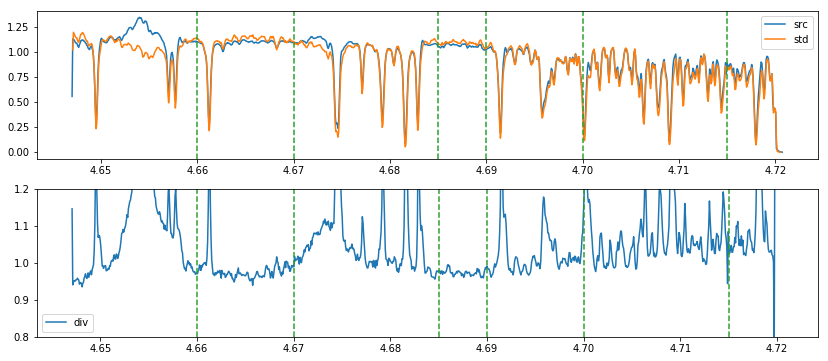

SNR: 35.833853520287654 144.85939053231576 18.811634423884644
Writing to:  ABAUR_HR2714_20130101_1122_M0_div.fits


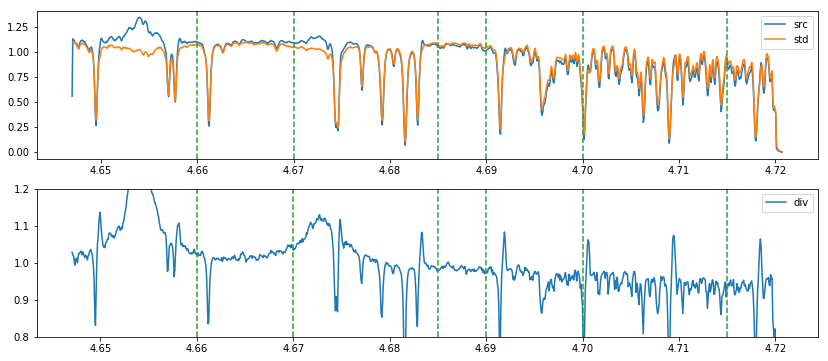

In [121]:
#20130101
srcfile='ABAUR_20130101_1056_spec1d1.fits' #there is a very large peak I cannot resolve. Might want to mess around with more
stdfile='HR1620_20130101_1028_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.35, dpix=0.3, mode='M0')

srcfile='ABAUR_20130101_1122_spec1d1.fits' #end very clean, choosing to ignore beginning.
stdfile='HR2714_20130101_1322_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.15, dpix=0.1, mode='M0')

#hdulist_src=fits.open(datadir+srcfile)    
#data_src=hdulist_src[1].data
#print(data_src['wave_pos'])

In [5]:
 #Read in data for source and standard, trying to find what values are irregular
hdulist_src=fits.open(datadir+srcfile)
data_src=hdulist_src[1].data
hdr_src=hdulist_src[0].header
hdulist_std=fits.open(datadir+stdfile)
data_std=hdulist_std[1].data
pflux_src=data_src['flux_pos']/np.median(data_src['flux_pos'])
nflux_src=data_src['flux_neg']/np.median(data_src['flux_neg'])
pflux_std=data_std['flux_pos']/np.median(data_std['flux_pos'])
nflux_std=data_std['flux_neg']/np.median(data_std['flux_neg'])
print(np.median(data_src['flux_pos'])+12000)
print(np.median(data_src['flux_neg']))
print(np.median(data_std['flux_pos']))
print(np.median(data_std['flux_neg']))

351927.71651227365
341054.0061800773
112477.17040453065
112057.83690296204


In [16]:
for n in range(len(pwave_src)): #printing data to find what looks irregular
    pwave_src=data_src['wave_pos']
    nwave_src=data_src['wave_neg']
    pwave_std=data_std['wave_pos']
    nwave_std=data_std['wave_neg']
    print(pwave_src[n])
print(pwave_src)
print(nwave_src)

4.646994
4.647063124453344
4.647132255373372
4.6472013927600875
4.647270536613488
4.6473396869335755
4.647408843720348
4.647478006973808
4.647547176693952
4.6476163528807835
4.6476855355343
4.647754724654503
4.647823920241392
4.647893122294967
4.647962330815228
4.6480315458021755
4.648100767255809
4.648169995176127
4.648239229563132
4.648308470416823
4.6483777177372
4.648446971524264
4.648516231778013
4.648585498498448
4.648654771685568
4.648724051339375
4.6487933374598684
4.648862630047048
4.648931929100913
4.649001234621464
4.6490705466087
4.649139865062623
4.649209189983232
4.649278521370527
4.649347859224508
4.649417203545176
4.649486554332529
4.649555911586567
4.649625275307292
4.649694645494703
4.6497640221488
4.649833405269583
4.649902794857053
4.649972190911207
4.650041593432048
4.6501110024195755
4.650180417873789
4.650249839794688
4.6503192681822725
4.650388703036544
4.6504581443575
4.650527592145143
4.650597046399472
4.650666507120487
4.650735974308189
4.650805447962576
4.65